## Regression Problem
#### Dataset Description:  
The dataset includes 9358 data samples of responses from 5 metal oxide chemical sensors embedded in an Air Quality Monitoring Device, recorded along with hours. The device was located on the field in a significantly polluted area in Italy. The data was collected to estimate benzene concentration with the response from the previously mentioned sensors, which are originally designed to monitor non-benzene substance concentration(i.e. there maybe a potential relationship between the concentration of benzene and the 5 kinds of non-benzene substance.).Consequently, the labels should be the true values of benzene concentration.  
The dataset is provided in S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia, On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario, Sensors and Actuators B: Chemical, Volume 129, Issue 2, 22 February 2008, Pages 750-757, ISSN 0925-4005.  

### LS Solution Approach by Changlin Jiang
#### Libraries and dataset importing

In [1]:
# import libraries
import csv
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import math

In [2]:
# read dataset from csv file
with open('AirQualityUCI.csv') as csv_file:
    csv_reader=csv.reader(csv_file, delimiter=',')
    date,time,CO_true,CO_measured,NMHC_true,C6H6_true,NMHC_measured,NOx_true,NOx_measured,NO2_true,NO2_measured,O3_measured,temp,RH,AH=[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)],[0 for i in range(9357)]
    line_count=0
    for row in csv_reader:
        if row[0]=="":
            break;
        if(line_count!=0):
            date[line_count-1],time[line_count-1],CO_true[line_count-1],CO_measured[line_count-1],NMHC_true[line_count-1],C6H6_true[line_count-1],NMHC_measured[line_count-1],NOx_true[line_count-1],NOx_measured[line_count-1],NO2_true[line_count-1],NO2_measured[line_count-1],O3_measured[line_count-1],temp[line_count-1],RH[line_count-1],AH[line_count-1]=row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12],row[13],row[14]
        line_count+=1

#### Data Cleaning
The missing values in the dataset was tagged with -200. To clean the dataset, the missing values are filled with the mean of the dimension.

In [3]:
# clean the data and label by replacing invalid value with mean
def clean_replace(data,labels):
    # clean the data
    m,n=np.shape(data)
    mean=[0 for i in range(m)]
    for i in range(m):
        sum=0
        count=0
        for j in range(n):
            if(data[i,j]>=0):
                sum+=data[i,j]
                count+=1
        mean[i]=sum/count
    for i in range(m):
        for j in range(n):
            if data[i,j]<0:
                data[i,j]=mean[i]

    # clean the label
    labels=np.array(labels).astype(np.float64)
    sum=0
    count=0
    for i in range(n):
        if labels[i]>=0:
            sum+=labels[i]
            count+=1
    mean=sum/count
    for i in range(n):
        if labels[i]<0:
            labels[i]=mean
    return data,labels

#### LS solution implementation

In [4]:
# implement LS solution
def ls_solution(data,labels):
    m,n=np.shape(data)
    data_hat=np.row_stack((data,[1 for i in range(n)])).T.astype(np.float64)
    w=la.inv(data_hat.T*data_hat)*data_hat.T*labels.T
    return w

#### Cross Validation Implementation

In [5]:
# Build cross validation function, return regression error for each test and derived labels
def cross_validation(data,labels,k:int):
    m,n=np.shape(data)
    data_with_labels=np.mat(np.row_stack((data,labels))).astype(np.float64)
    a=n//k
    fold=[0 for i in range(k)]
    for i in range(k):
        if i!=k-1:
            fold[i]=data_with_labels[:,i*a:(i+1)*a].astype(np.float64)
        else:
            fold[i]=data_with_labels[:,i*a:].astype(np.float64)
    reg_error=[0 for i in range(k)]
    labels_derived=np.mat([0 for i in range(n)]).astype(np.float64).T
    
    for i in range(k):
        test_data=fold[i].astype(np.float64)
        mi,ni=np.shape(fold[i])
        training_data=np.mat([[0 for j in range(n-ni)] for i in range(m+1)]).astype(np.float64)
        sample_number=0
        for j in range(k):
            if j==i:
                continue
            mj,nj=np.shape(fold[j])
            training_data[:,sample_number:sample_number+nj]=fold[j]
            sample_number=sample_number+nj
        # Algorithm implementation
        w=ls_solution(training_data[:m,:],training_data[m,:])
        test_data_hat=np.row_stack((test_data[:m,:],np.mat([1 for x in range(ni)])))
        y=test_data_hat.T*w
        if i!=k-1:
            labels_derived[i*a:(i+1)*a]=y
        else:
            labels_derived[i*a:]=y
        reg_error[i]=la.norm(y-labels,2)
    overall_error=la.norm(reg_error)
    return reg_error,labels_derived,overall_error

#### Overall process implementation
The pipeline implemented is as below:  
- Data importing:  
Import data from csv file and save each dimension into a individual list.
- Data cleaning:
Fill all the missing values in data with the mean of the dimension.
- Algorithm implement:
Implement LS solution to learn the dataset.
- Algorithm evaluation:
Build K-folds cross validation to compute the regression error of the algorithm
- Parameter determination:
Run K-folds cross validation with K in a linear array to find the best K for this certain dataset.

In [6]:
# Define overall process function to show the results
def ls_regression(data,labels):
    m,n=np.shape(np.mat(data))
    if m>1:
        data=np.row_stack(data)
    data=np.mat(data).astype(np.float64)
    data,labels=clean_replace(data,labels)
    # Implement LS regression nand cross validation to find the best K
    k=[2,3,4,5,6,7,8,9,10]
    overall_error=[0 for i in range(9)]
    for i in range(9):
        overall_error[i]=cross_validation(data,labels,k[i])[2]
    # Plot the K-Error plot to show the best K
    plt.figure(1)
    plt.plot(k,overall_error)
    plt.title('K-Error Plot')
    print("The best K is ",k[overall_error.index(min(overall_error))])
    # Plot the regression result derived by the best K in a predicted-versus-measured scatter plot
    reg_error,labels_derived,overall_error=cross_validation(data,labels,k[overall_error.index(min(overall_error))])
    labels_derived=np.array(labels_derived).reshape(-1,1)
    labels=np.array(labels).reshape(1,-1).T
    plt.figure(2)
    plt.scatter(labels,labels_derived,color='b')
    ymax=max([max(labels),max(labels_derived)])
    plt.plot([0,max(labels)],[0,max(labels)], color='r', linewidth=1, alpha=0.6)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Measured Labels')
    plt.title('Overall L2-Loss Regression Error={}'.format(overall_error))

In [164]:
data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
labels=C6H6_true
#ls_regression(data,labels)

compare to sklearn least regression
error: 114.61370295241286


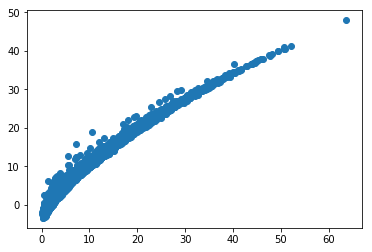

In [410]:
print("compare to sklearn least regression")
from sklearn import linear_model
reg=linear_model.LinearRegression()
reg.fit(clean_data.T,labels)
y=reg.predict(clean_data.T)
print ("error:",np.linalg.norm(labels-y))
plt.scatter(labels,y)
plt.show()

## random forest approach by Chaoji Zuo

When I started solving this problem, I did not use any other optimazation methods, I just try to put all the cleaned data into the Random Forest Regression model and did not know clearly what would I get.

And the result really surprise me, the error is really small and random forest looks like a perfect solution for this dataset.

In [207]:
from sklearn.ensemble import RandomForestRegressor
data=np.array(data).astype(np.float64)
data,labels=clean_replace(data,labels)
clean_data=pd.DataFrame(data.T)
clean_data["y"]=pd.Series(labels)
labels=clean_data["y"]
clean_data=clean_data.drop(["y"],axis=1)
X_train, y_train = clean_data[:6000],labels[:6000]
X_test,y_test=clean_data[6000:],labels[6000:]

In [212]:
X_train.sample(2)

,0,1,2,3,4,5,6,7
1981,1225.0,1067.0,760.0,1922.0,1102.0,16.9,80.9,1.5472
2967,986.0,922.0,820.0,1586.0,971.0,21.7,46.3,1.1867


In [209]:
regr=RandomForestRegressor()
regr.fit(clean_data,labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

ValueError: x and y must be the same size

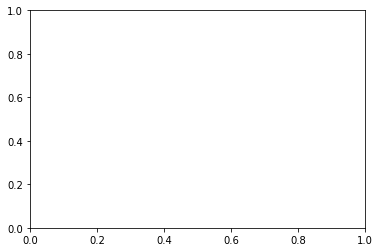

In [210]:

plt.scatter(res,labels)
plt.plot([min(labels),max(labels)],[min(labels),max(labels)],c='r')
plt.title("first try on the whole datasets")
plt.xlabel("true values")
plt.ylabel("predict values")
plt.show()
print("2-norm error:",np.linalg.norm(res-labels))
print("R^2 score of predict values:",regr.score(clean_data,labels))

However, this may be just because I use the training data to do the test. And it may have some kind of over-fitting so I then leave some test data and train the model using the training data.

And It still get a great performance.

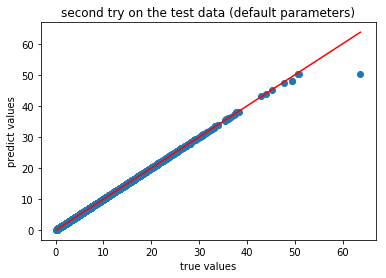

2-norm error: 13.76246286644514


In [234]:
regr=RandomForestRegressor()
regr.fit(np.array(X_train)[:,1:2],y_train)
res=regr.predict(np.array(X_test)[:,1:2])

plt.scatter(y_test,res)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='r')
plt.title("second try on the test data (default parameters)")
plt.xlabel("true values")
plt.ylabel("predict values")
plt.show()
print("2-norm error:",np.linalg.norm(res-y_test))
#print("R^2 score of predict values:",regr.score(X_test,y_test))

So I think this model doesn't have a over-fitting problem.

It is a very sutiable model to this dataset.

Since I just use the default parameters, I think maybe I can get a even better result by using the cross validation to train the best parameters.

In [192]:
from sklearn.model_selection import GridSearchCV

X_train, y_train = clean_data[:6000],labels[:6000]

rfr = RandomForestRegressor()
tuned_parameters = [{'max_features':[1,2,3,4,5,6,7,8]}]

clf = GridSearchCV(estimator=rfr,param_grid=tuned_parameters, cv=5, n_jobs=1)

clf.fit(X_train, y_train)
print('Best parameters:')
print(clf.best_params_)

Best parameters:
{'max_features': 8}


In [227]:
X_train[0]

0       1360.0
1       1292.0
2       1402.0
3       1376.0
4       1272.0
5       1197.0
6       1185.0
7       1136.0
8       1094.0
9       1010.0
10      1011.0
11      1066.0
12      1052.0
13      1144.0
14      1333.0
15      1351.0
16      1233.0
17      1179.0
18      1236.0
19      1286.0
20      1371.0
21      1310.0
22      1292.0
23      1383.0
24      1581.0
25      1776.0
26      1640.0
27      1313.0
28       965.0
29       913.0
         ...  
5970     705.0
5971     710.0
5972     713.0
5973     703.0
5974     738.0
5975     795.0
5976     861.0
5977     836.0
5978     812.0
5979     771.0
5980     711.0
5981     741.0
5982     696.0
5983     692.0
5984     679.0
5985     676.0
5986     681.0
5987     683.0
5988     704.0
5989     767.0
5990     964.0
5991     925.0
5992     883.0
5993     894.0
5994     881.0
5995     867.0
5996     856.0
5997     862.0
5998     891.0
5999     931.0
Name: 0, Length: 6000, dtype: float64

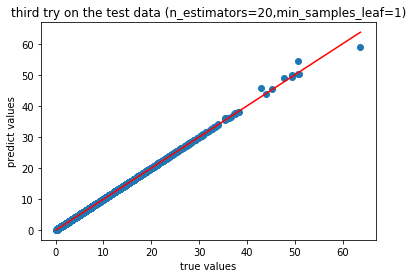

2-norm error: 7.18762263679562
R^2 score of predict values: 0.9997032231332875


In [65]:
regr=RandomForestRegressor(n_estimators=20,min_samples_leaf=1)
regr.fit(X_test,y_test)
res=regr.predict(X_test)

plt.scatter(y_test,res)
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)],c='r')
plt.title("third try on the test data (n_estimators=20,min_samples_leaf=1)")
plt.xlabel("true values")
plt.ylabel("predict values")
plt.show()

print("2-norm error:",np.linalg.norm(res-y_test))
print("R^2 score of predict values:",regr.score(X_test,y_test))

I really got a better solution using the best parameters of "min_samples_leaf" and "n_estimators".

But the progress was not very significant, because the former soultion is great enough.

### model review

In [339]:
print("shape of decision path:",regr.decision_path(X_test)[0].toarray().shape)

shape of decision path: (3357, 15190)


In [393]:
from sklearn.tree import export_graphviz
estimator = regr.estimators_[0]
export_graphviz(estimator,feature_names=['CO_measured','NMHC_measured','NOx_measured','NO2_measured','O3_measured','temp','RH','AH'],out_file='tree.dot')

In [162]:
print("feature importances:")
print(regr.feature_importances_)

feature importances:
[1.14605361e-04 9.99039715e-01 6.80067340e-05 2.52241515e-04
 8.17125779e-05 1.64029936e-04 1.43650141e-04 1.36038627e-04]


In [193]:
data1=(NMHC_measured)
data1=np.array(data1).astype(np.float64)
data1,labels=clean_replace(data1,labels)
data1=np.array(data1)
reg=linear_model.LinearRegression()
reg.fit(data1.T,labels)
y=reg.predict(data1.T)
plt.scatter(labels,y)
plt.title("least sqaure regression whitout the most importance feature")
print ("error:",np.linalg.norm(labels-y))

ValueError: not enough values to unpack (expected 2, got 1)

#### Discussion:
At the start of coding this algorithm, there was a great issue. The dataset was provided by UCI, which didn't tag the labels dimension in all the 14 dimensions. Picking the right attribute took a long period of time. The process was as below.  
Firstly, I assumed UCI just provided this dataset for free-researching, i.e. there was no explicit attribute in all the attributes so that we could pick any one by our requirement to check our algorithm freely.  
Our first pick was picking the true value of CO as the labels attribute and estimate it with the responses from the 5 sensors.Firstly I directly plotted a true-versus-measured plot of CO concentration to find out if it fitted linear model.

Text(0.5,1,'CO_True VS CO_Measured')

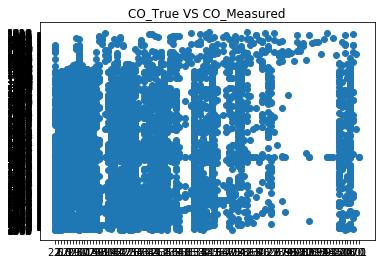

In [12]:
plt.scatter(CO_true,CO_measured)
plt.title('CO_True VS CO_Measured')

It can be indicated from the plot that the model is totally non-linear.The response of the sensor is likely to be random when the true concentration of CO is exactly at some certain value, plotted as vertical straight-line-like shapes in the scatter plot.  
That was the reason why I decided to treat the problem as random model, and directly implement LS solution to find out one answer:
Is there any potential relationships between the responses from the 5 sensors so that I can input all of them to get a better result on when measuring concentration of one certain kind of the substance? That is to say,if I input all the 5 measured attribute into regression algorithm, can I get a lower regression error to the true CO concentration than only inputting the measured CO concentration?  
To find out the answer, firstly I put only the measured CO concentration into LS regression algorithm to get the error:

The best K is  2


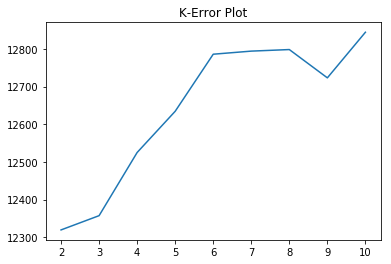

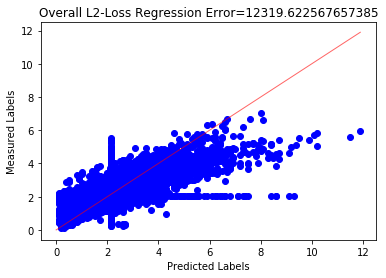

In [13]:
ls_regression(CO_measured,CO_true)

Then I implemented the algorithm with input dataset of all the 5 sensors responses, the result was:

The best K is  5


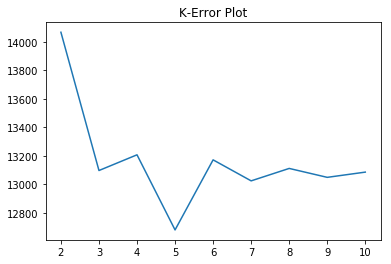

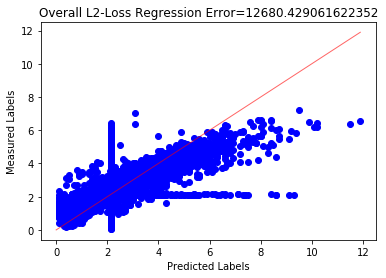

In [14]:
data=(CO_measured,NMHC_measured,NOx_measured,NO2_measured,O3_measured,temp,RH,AH)
labels=CO_true
ls_regression(data,labels)

It can be indicated by comparing the two L2-Loss that there is no enhancement by adding more attributes to the input.It seems hard to continue using the same attribute as labels.  
Finally I directly read the paper cited on the UCL dataset page and found out that the purpose of the collection of this dataset was to estimate the potential of true benzene concentration and the responses of sensors. By implementing the same algorithm on such data and labels input I got the above result.The result is the cell above this discussion section.

In [8]:
import pandas as pd

In [10]:
alldata=pd.read_csv("AirQualityUCI.csv")

In [14]:
random_alldata=alldata.sample(frac=1)

In [17]:
random_alldata.sample(2)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
1588,2004/5/15,22:00:00,1.6,1101.0,-200.0,9.9,972.0,95.0,879.0,97.0,1552.0,1001.0,20.2,34.3,0.8017,NaN,NaN
5714,2004/11/3,20:00:00,3.3,1266.0,-200.0,18.7,1261.0,355.0,541.0,97.0,1807.0,1285.0,22.4,55.2,1.4735,NaN,NaN


In [195]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale

In [236]:
lsr=Lasso(alpha=0.1)
X_nor=scale(clean_data,axis=0)
X_train=X_nor[:6000]
X_test=X_nor[6000:]
lsr.fit(X_train,y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [197]:
X_train.std(axis=0)

array([0.99630398, 0.98640005, 0.96467755, 0.81962006, 0.91941378,
       0.84672978, 0.97783847, 0.87545949])

In [198]:
#py=lsr.predict()

0.33 : 84.34333547581284


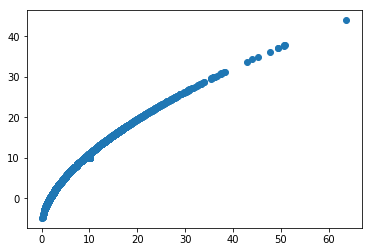

In [205]:
aArr=np.linspace(0.33,0.5,1)
for i in aArr:
    lsr=Lasso(alpha=i)
    py=lsr.fit(X_train[:,1:2],y_train)
    py=lsr.predict(X_test[:,1:2])
    #plt.figure()
    plt.scatter(y_test,py)
    print(i,":",np.linalg.norm(py-y_test))
    #plt.show()
    #print(lsr.coef_)

error: 86.32763680302027


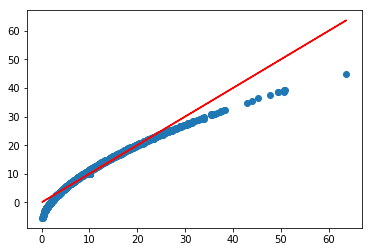

In [202]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(X_train[:,0:2],y_train)
y=reg.predict(X_test[:,0:2])
print ("error:",np.linalg.norm(y_test-y))
plt.scatter(y_test,y)
plt.plot(y_test,y_test,c='r')
plt.show()

error: 97.52281583105727


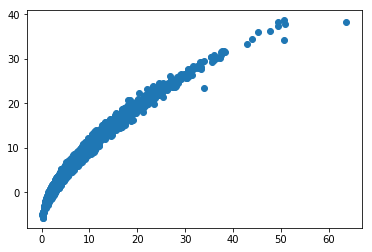

error: 98.79088820645


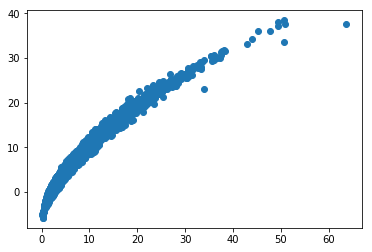

error: 99.95641748464166


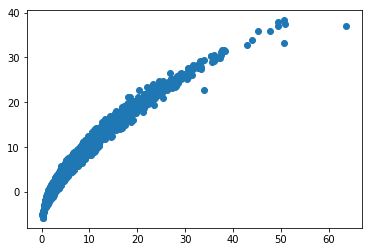

error: 101.04834402567231


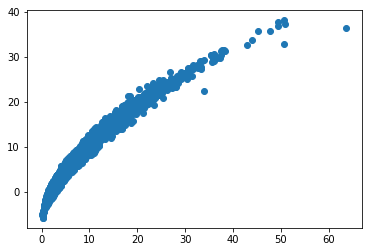

error: 102.07676637180856


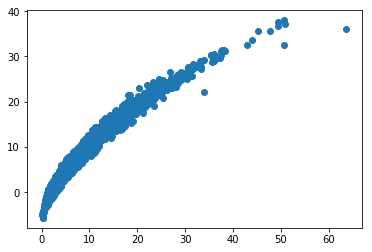

error: 103.0495371564706


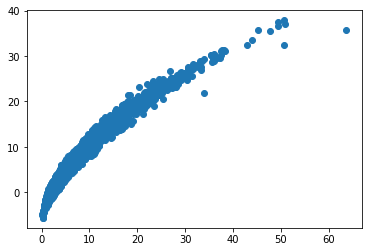

error: 103.9763190912232


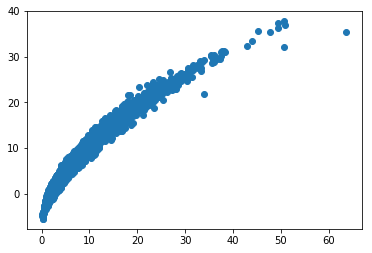

error: 104.87017523400779


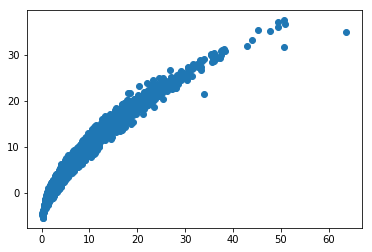

error: 105.85398752069517


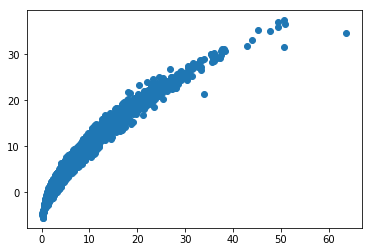

error: 106.84254675223909


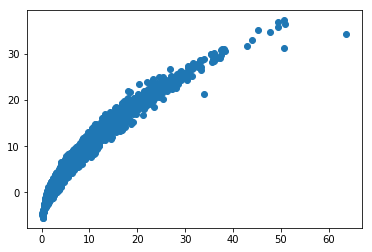

error: 107.83452949077613


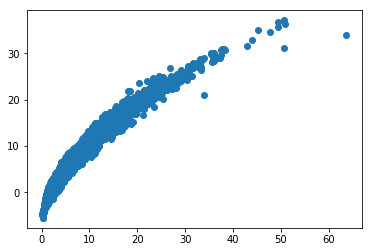

error: 108.8200293161335


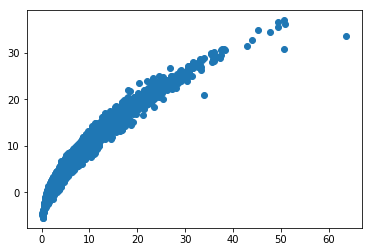

error: 109.79542094602542


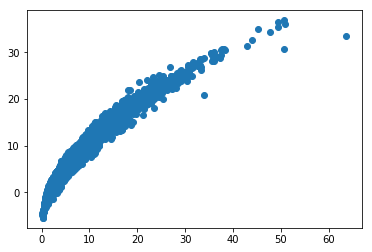

error: 110.7584050192092


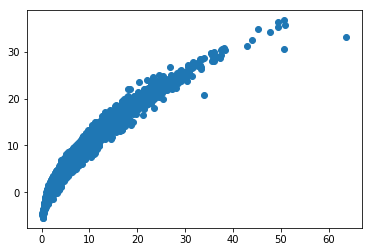

error: 111.71122052507874


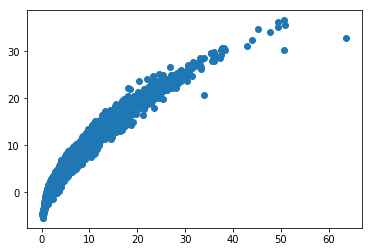

error: 112.64645065318388


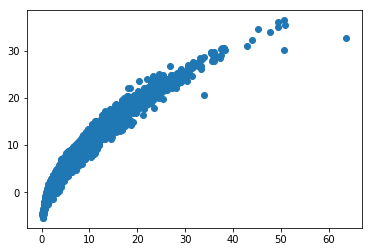

error: 113.57027886488784


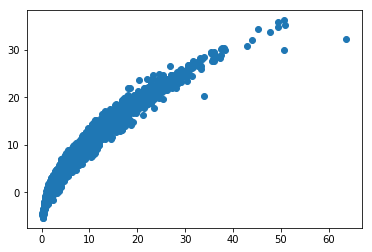

error: 114.47757725254687


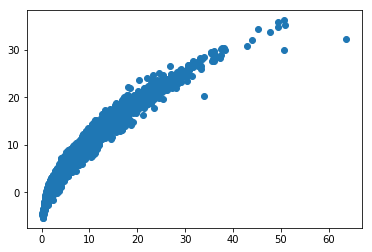

error: 115.3714578906194


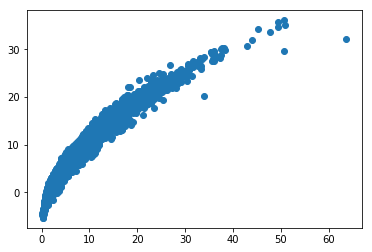

error: 116.25500880198757


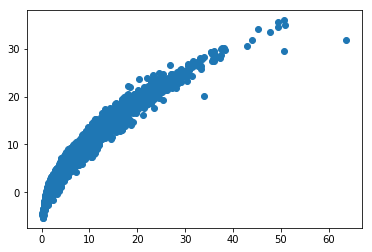

error: 117.12423611671275


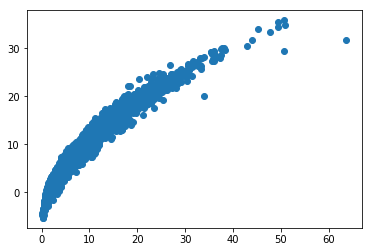

error: 117.98426155701044


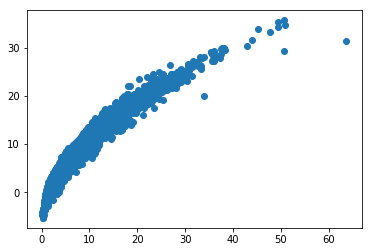

error: 118.83183850688427


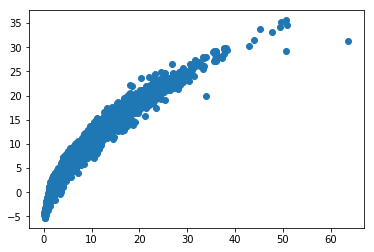

error: 119.67151759952822


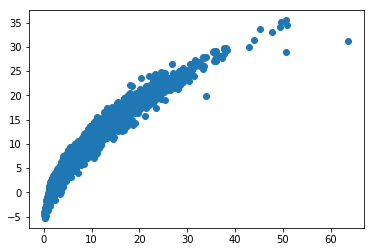

error: 120.50045938284353


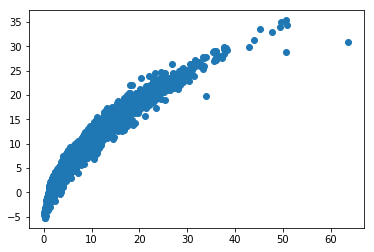

error: 121.32283862988159


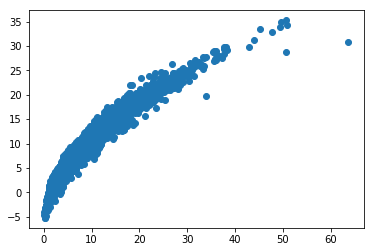

error: 122.11170272972015


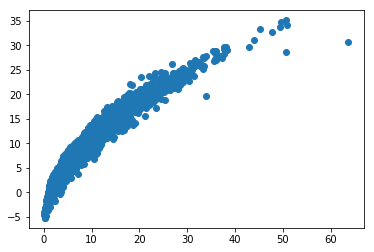

error: 122.87708256830467


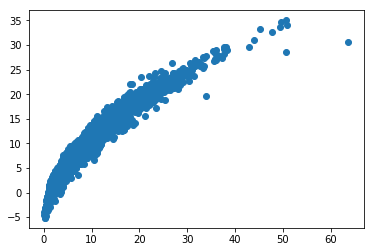

error: 123.63970234634925


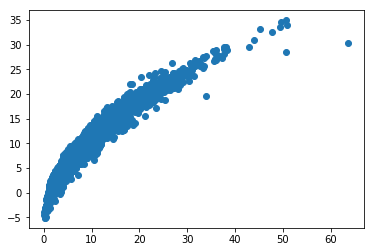

error: 124.4020406138214


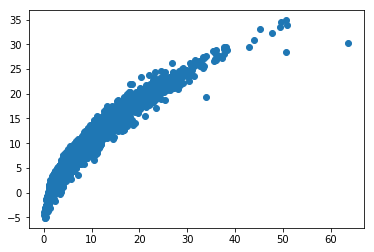

error: 125.16211400197655


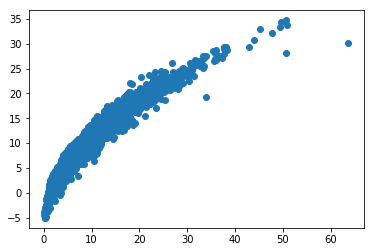

error: 125.92246989993835


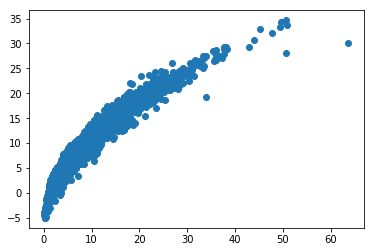

error: 126.68198857569814


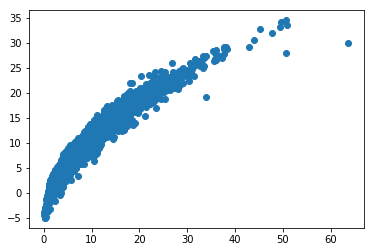

error: 127.43987532102489


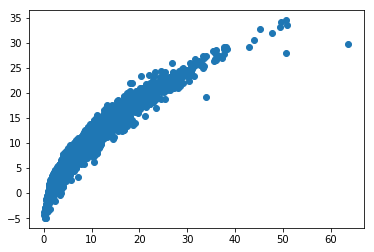

error: 128.19853685837302


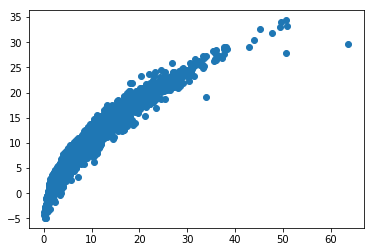

error: 128.95686627232595


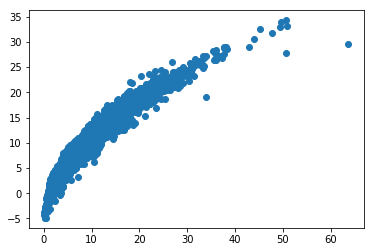

error: 129.7138051991086


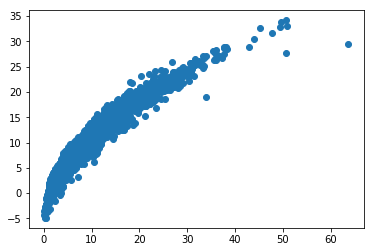

error: 130.4720656972861


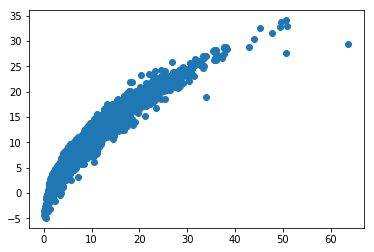

error: 131.23032661278998


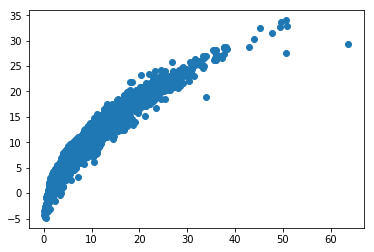

error: 131.9886809855369


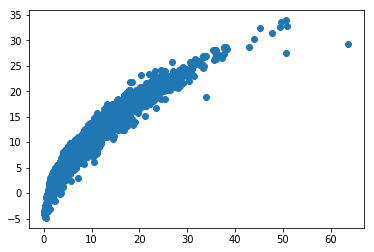

error: 132.7459330394868


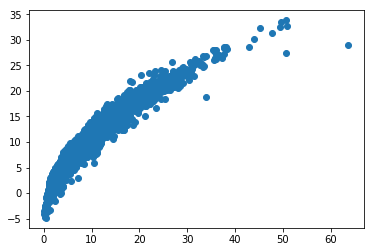

error: 133.50490636442484


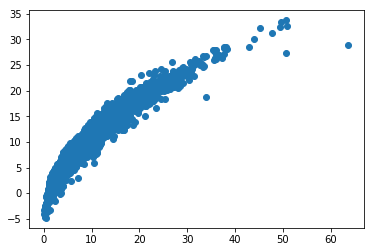

error: 134.26416942208255


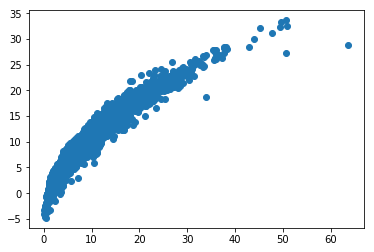

error: 135.02377169062316


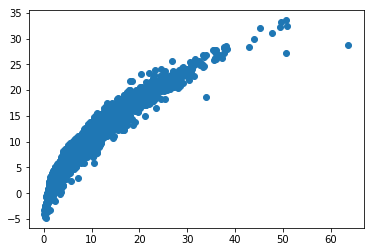

error: 135.78376012747773


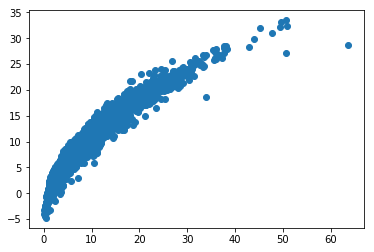

error: 136.5428923546267


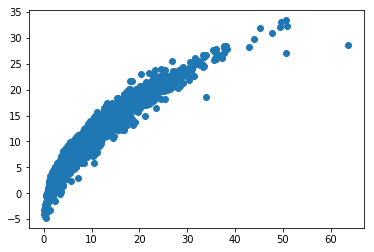

error: 137.3039441981911


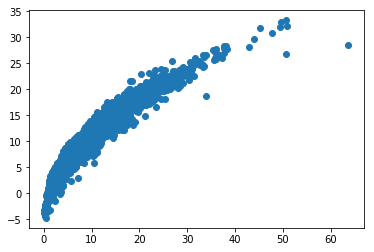

error: 138.0654629357679


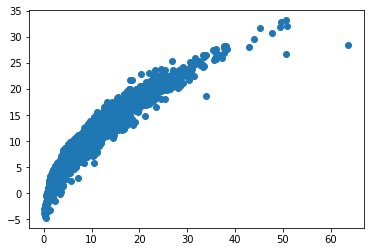

error: 138.82746287906633


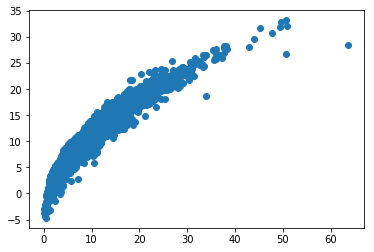

error: 139.58995877838507


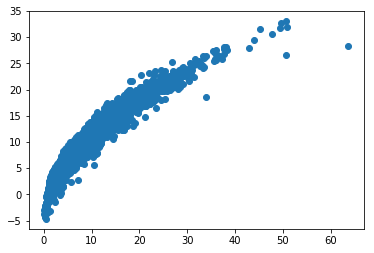

In [159]:
from sklearn.linear_model import ElasticNet
for i in aArr:
    reg=ElasticNet(alpha=i)
    reg.fit(X_train,y_train)
    y=reg.predict(X_test)
    print ("error:",np.linalg.norm(y_test-y))
    plt.scatter(y_test,y)
    plt.show()

In [168]:
X_train[:,1:2].shape

(6000, 1)

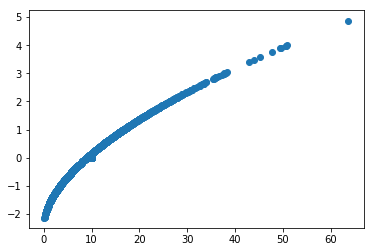

In [237]:
plt.scatter(y_test,X_test[:,1:2])